In [1]:
import sys
#sys.path.append("../scripts/")

from matplotlib.animation import PillowWriter    #For saving animation
import numpy as np
import math
import random
import copy


In [2]:
import sys
sys.path.append("../scripts/")
from gridmap import *
from matplotlib.animation import PillowWriter    
import math
import random
import copy


# In[2]:


class RRT():
    def __init__(self, grid_map_world, ratioPointGoal=0.9, drawVertex=False):    
        self.world = grid_map_world
        self.grid_map = grid_map_world.grid_map
        self.vertex = []    #[x, y, cost]
        self.edge = []  #[id1, id2]
        self.candidate = []
        self.parent = []    #[x, y]
        self.id = []    #[x, y]
        self.isStart = True
        self.isFinish = False
        self.isPathDraw = False
        self.ratePointGoal = ratioPointGoal
        self.marker_size = 4
        self.start_cordinate = [(self.world.start_index[0]+1/2)*self.world.grid_step[0], (self.world.start_index[1]+1/2)*self.world.grid_step[1]]
        self.goal_cordinate = [(self.world.goal_index[0]+1/2)*self.world.grid_step[0], (self.world.goal_index[1]+1/2)*self.world.grid_step[1]]
        self.drawVertexflag = drawVertex
    
    def draw(self, ax, elems):
        xs, xn, xp = self.RRT()
        
        self.drawEdge(ax, elems)    #Draw all edges
        if(self.drawVertexflag):
            self.drawVertex(ax, elems)    #Draw all vertices
        if(not(self.isFinish)):
            self.drawSamplingPoint(ax, elems, xs)    #Draw sampling points
            self.drawExtendedEdge(ax, elems, xn, xp)    #Draw extended edges
        self.drawPath(ax, elems)    #Drawing of the obtained route
    
    def RRT(self):
        if(self.isFinish):
            return None, None, None       
        if(self.isStart):
            x, y = self.start_cordinate
            self.vertex.append([x, y, 0.0])
            self.parent.append(0)
            self.isStart = False
            self.id.append([x, y])   
        xn, yn = None, None
        xp, yp = None, None
        xp_n, yp_n = None, None
        cost_n = None
        nearest_id = None
        isFindVertex = False
        while(isFindVertex == False):    #Repeat until you get a point to tie
            #sampling
            if(random.random() > self.ratePointGoal and not(self.isFinish)):
                xp, yp = self.goal_cordinate    #Select a goal with a certain probability
            else:
                r1 = random.random()
                r2 = random.random()
                xp = self.world.grid_num[0]*self.world.grid_step[0]*r1
                yp = self.world.grid_num[1]*self.world.grid_step[1]*r2
                xp, yp = self.returnGoalGrid([xp, yp])
            
            #Find new points and check for collisions
            candidate = copy.copy(self.vertex)
            while(1):
                xn, yn, xp_n, yp_n, cost_n, nearest_id = self.getNearestVertex([xp, yp], candidate)    #Search for the closest vertex to [xp, yp]
                if(self.isGoal([xn, yn])):
                    [xn, yn] = self.goal_cordinate
                    isFindVertex = True
                    self.isFinish = True
                    break
                #Exclude adjacent nodes within a radius of 1.1 grid_step
                #If you hit an obstacle or go off the map xn=xp_n, yn=yp_n
                if(math.sqrt((xn-xp_n)**2 + (yn-yp_n)**2) < 0.001*math.sqrt(self.world.grid_step[0]**2+self.world.grid_step[1]**2)):
                    candidate.pop(nearest_id)
                    if(candidate == []):
                        break
                else:
                    isFindVertex = True
                    break
        
        cost_new = cost_n + math.sqrt((xn-xp_n)**2 + (yn-yp_n)**2)
        self.vertex.append([xn, yn, cost_new])
        self.edge.append([xn, yn, xp_n, yp_n])
        self.parent.append([xp_n, yp_n])
        self.id.append([xn, yn])
        return [xp, yp], [xn, yn], [xp_n, yp_n]    #Returns sampling point, new point, parent point
    
    #Find the closest vertex and return the coordinates and cost of the two vertices
    def getNearestVertex(self, xNew, candidate):
        dis = float('inf')
        dis_collision = float('inf')
        xNearest = []
        xNearest_collision = []
        cost_n = 0
        cost_n_collision = 0
        nearest_id = 0
        nearest_id_collision = 0
        for x in candidate:
            collision = 1
            #collision, _, _ = self.collisionFree(x, xNew, type2=False)
            if(collision == 1):
                if(dis > (xNew[0]-x[0])**2 + (xNew[1]-x[1])**2 and xNew != x):
                    dis = (xNew[0]-x[0])**2 + (xNew[1]-x[1])**2
                    xNearest = [x[0], x[1]]
                    cost_n = x[2]
                    nearest_id = candidate.index([x[0], x[1], x[2]])
            elif(collision == 0):
                if(dis_collision > (xNew[0]-x[0])**2 + (xNew[1]-x[1])**2 and xNew != x):
                    dis_collision = (xNew[0]-x[0])**2 + (xNew[1]-x[1])**2
                    xNearest_collision = [x[0], x[1]]
                    cost_n_collision = x[2]
                    nearest_id_collision = candidate.index([x[0], x[1], x[2]])
                    
        if(xNearest == []):
            xNearest = xNearest_collision
            cost_n_collision = cost_n
            nearest_id = nearest_id_collision
        
        isCollision = self.collisionFree(xNearest, xNew, type2=True)
        if(isCollision[0] == 0):
            return xNearest[0], xNearest[1], xNearest[0], xNearest[1], cost_n, nearest_id
        elif(isCollision[0] == 2):
            return isCollision[1], isCollision[2], xNearest[0], xNearest[1], cost_n, nearest_id
        else:
            return xNew[0], xNew[1], xNearest[0], xNearest[1], cost_n, nearest_id
    
    #Is there an obstacle between x1 and x2?
    def collisionFree(self, x1, x2, type2=True):
        dx = x2[0] - x1[0]
        dy = x2[1] - x1[1]
        dr = dx**2 + dy**2
        x_next = x1
        #Extend from x1 little by little and check if there are any obstacles
        while(math.sqrt((x_next[0]-x1[0])**2+(x_next[1]-x1[1])**2) < math.sqrt((x1[0]-x2[0])**2+(x1[1]-x2[1])**2)):
            x_next = [x_next[0]+self.world.grid_step[0]*0.01*dx/dr, x_next[1]+self.world.grid_step[0]*0.01*dy/dr]
            if(self.isObstacle(x_next)):
                return [0, x1[0], x1[1]]    #If you are caught in an obstacle
            if((self.isGoal(x_next) and not(self.isGoal(x1)) and not(self.isGoal(x2))) and type2):
                return [1, self.goal_cordinate[0], self.goal_cordinate[1]]
            if(type2 and math.sqrt((x_next[0]-x1[0])**2+(x_next[1]-x1[1])**2) > 2*math.sqrt(self.world.grid_step[0]**2+self.world.grid_step[1]**2)):
                return [2, x_next[0], x_next[1]]    #Not sandwiched between obstacles, but limited to a certain distance and returned that point
        return [1, x2[0], x2[1]]    #Not sandwiched between obstacles even if tied directly
    
    def isObstacle(self, x):
        x_num = math.floor(x[0]/self.world.grid_step[0])
        y_num = math.floor(x[1]/self.world.grid_step[1])
        if(x_num >= self.world.grid_num[0] or y_num >= self.world.grid_num[1] or x_num < 0 or y_num < 0):
            return True    #Obstacles outside the map
        if(self.grid_map[x_num][y_num] == '0'):
            return True    #In the case of obstacles
        else:
            return False

    def isGoal(self, x):
        x_num = math.floor(x[0]/self.world.grid_step[0])
        y_num = math.floor(x[1]/self.world.grid_step[1])
        if(x_num >= self.world.grid_num[0] or y_num >= self.world.grid_num[1] or x_num < 0 or y_num < 0):
            return False
        if(self.grid_map[x_num][y_num] == '3'):
            return True
        else:
            return False
        
    #Returns the goal coordinates if in the goal grid
    def returnGoalGrid(self, x):
        x_num = math.floor(x[0]/self.world.grid_step[0])
        y_num = math.floor(x[1]/self.world.grid_step[1])
        if(x_num >= self.world.grid_num[0] or y_num >= self.world.grid_num[1] or x_num < 0 or y_num < 0):
            return [0, 0]
        if(self.grid_map[x_num][y_num] == '3'):
            return [(self.world.goal_index[0]+1/2)*self.world.grid_step[0], (self.world.goal_index[1]+1/2)*self.world.grid_step[1]]
        else:
            return x 
    
    #id get
    def get_id(self, x):
        return self.id.index(x)
    
    def drawVertex(self, ax, elems):
        for x in self.vertex:
            elems += ax.plot(x[0], x[1], marker='.', markersize=self.marker_size, color="Blue")
    
    def drawEdge(self, ax, elems):
        for edge in self.edge:
            x1, y1, x2, y2 = edge
            elems += ax.plot([x1, x2], [y1, y2], color="cyan", alpha=1.0)
            
    def drawExtendedEdge(self, ax, elems, x1, x2):
        elems += ax.plot([x1[0], x2[0]], [x1[1], x2[1]], color="blue", alpha=0.5)        
    
    def drawSamplingPoint(self, ax, elems, x):
        elems += ax.plot(x[0], x[1], marker='.', color="red")
    
    def drawPath(self, ax, elems):
        if(self.isFinish):
            #Start from the goal
            id = self.get_id(self.goal_cordinate)
            distance = 0
            while(id != 0):    #Repeat until start (id = 0)
                x1, y1 = self.id[id]
                x2, y2 = self.parent[id]
                id = self.get_id([x2, y2])
                elems += ax.plot([x1, x2], [y1, y2], color="red")
                distance += math.sqrt((x1-x2)**2 + (y1-y2)**2)
            dis_str ="Distance = %.4f" % (distance)
            elems.append(
                ax.text(
                    self.world.grid_step[0]*self.world.grid_num[0]*0.6,
                    self.world.grid_step[1]*self.world.grid_num[1]*1.02,
                    dis_str,
                    fontsize=10
                )
            )




Could not import drmaa. Only local multiprocessing supported.


In [3]:
class RRTstar(RRT):
    def __init__(self, grid_map_world, ratioPointGoal=0.9, R=3, drawVertex=False, drawReconnectAreaflag=False):
        super(RRTstar, self).__init__(grid_map_world, ratioPointGoal=0.9, drawVertex=drawVertex)
        self.marker_size = 6
        self.R = R
        self.epsilon =0.1*math.sqrt(self.world.grid_step[0]**2+self.world.grid_step[1]**2)
        self.start_cordinate = [(self.world.start_index[0]+1/2)*self.world.grid_step[0], (self.world.start_index[1]+1/2)*self.world.grid_step[1]]
        self.goal_cordinate = [(self.world.goal_index[0]+1/2)*self.world.grid_step[0], (self.world.goal_index[1]+1/2)*self.world.grid_step[1]]
        self.drawReconnectAreaflag = drawReconnectAreaflag
    
    def draw(self, ax, elems):
        xs, xn, xp = self.RRTstar()
        
        if(self.drawReconnectAreaflag):
            self.drawReconnectArea(ax, elems, xn)
        self.drawEdge(ax, elems)    #Draw all edges
        if(self.drawVertexflag):
            self.drawVertex(ax, elems)    #Draw all vertices
        self.drawSamplingPoint(ax, elems, xs)    #Draw sampling points
        self.drawPath(ax, elems)    #Drawing of the obtained route
        
    def RRTstar(self):
        if(self.isStart):
            x, y = self.start_cordinate
            self.vertex.append([x, y, 0.0])
            self.parent.append(0)
            self.isStart = False
            self.id.append([x, y])
        
        xn, yn = None, None
        xp, yp = None, None
        xp_n, yp_n = None, None
        cost_n = None
        nearest_id = None
        isFindVertex = False
        while(isFindVertex == False):    #Repeat until you get a point to tie
            #sampling
            if(random.random() > self.ratePointGoal and not(self.isFinish)):
                xp, yp = self.goal_cordinate   #Select a goal with a certain probability
            else:
                r1 = random.random()
                r2 = random.random()
                xp = self.world.grid_num[0]*self.world.grid_step[0]*r1
                yp = self.world.grid_num[1]*self.world.grid_step[1]*r2
                xp, yp = self.returnGoalGrid([xp, yp])
                if(self.isObstacle([xp, yp])):
                    continue
            
            candidate = copy.copy(self.vertex)
            while(1):
                xn, yn, xp_n, yp_n, cost_n, nearest_id = self.getNearestVertex([xp, yp], candidate)    #Search for the vertex closest to [xp, yp]
                if(self.isGoal([xn, yn])):
                    [xn, yn] = self.goal_cordinate
                    isFindVertex = True
                    self.isFinish = True
                    break
                #Exclude adjacent nodes within a radius of 1.1 grid_step
                #If you hit an obstacle or go out of the map, xn = xp_n, yn = yp_n
                if(math.sqrt((xn-xp_n)**2 + (yn-yp_n)**2) < 0.001*math.sqrt(self.world.grid_step[0]**2+self.world.grid_step[1]**2)):
                    candidate.pop(nearest_id)
                    if(candidate == []):
                        break
                else:
                    isFindVertex = True
                    break
        
        cost_new = cost_n + math.sqrt((xn-xp_n)**2 + (yn-yp_n)**2)
        self.vertex.append([xn, yn, cost_new])
        self.edge.append([xn, yn, xp_n, yp_n])
        self.parent.append([xp_n, yp_n])
        self.id.append([xn, yn])
        
        #Edge change
        for neigbor in self.getNeigborVertex([xn, yn]):
            if(neigbor[2] > cost_new + math.sqrt((xn-neigbor[0])**2 + (yn-neigbor[1])**2)):
                isCollision, _, _ = self.collisionFree(neigbor, [xn, yn], type2=False)
                if(isCollision == 0 or isCollision == 2):
                    continue
                parent_vertex = self.parent[self.get_id([neigbor[0], neigbor[1]])]
                self.edge.remove([neigbor[0], neigbor[1], parent_vertex[0], parent_vertex[1]])
                self.edge.append([neigbor[0], neigbor[1], xn, yn])
                self.parent[self.get_id([neigbor[0], neigbor[1]])] = [xn, yn]
                self.changeChildCost(neigbor)  
        
        return [xp, yp], [xn, yn], [xp_n, yp_n]    #Returns sampling point, new point, parent point
    
    #Find the closest vertex and return the coordinates and cost of the two vertices
    def getNearestVertex(self, xNew, candidate):
        dis = float('inf')
        dis_collision = float('inf')
        xNearest = []
        xNearest_collision = []
        cost_n = 0
        cost_n_collision = 0
        nearest_id = 0
        nearest_id_collision = 0
        for x in candidate:
            if(dis > x[2] + (xNew[0]-x[0])**2 + (xNew[1]-x[1])**2 and xNew != x):
                dis = x[2] + (xNew[0]-x[0])**2 + (xNew[1]-x[1])**2
                xNearest = [x[0], x[1]]
                cost_n = x[2]
                nearest_id = candidate.index([x[0], x[1], x[2]])
                    
        if(xNearest == []):
            xNearest = xNearest_collision
            cost_n_collision = cost_n
            nearest_id = nearest_id_collision            
        
        isCollision = self.collisionFree(xNearest, xNew, type2=False)
        if(isCollision[0] == 0):
            return xNearest[0], xNearest[1], xNearest[0], xNearest[1], cost_n, nearest_id
        elif(isCollision[0] == 2):
            return isCollision[1], isCollision[2], xNearest[0], xNearest[1], cost_n, nearest_id
        else:
            return xNew[0], xNew[1], xNearest[0], xNearest[1], cost_n, nearest_id
    
    #Returns all vertices in the neighborhood
    def getNeigborVertex(self, x):
        N = len(self.vertex)
        r = self.R * math.pow(math.log(N)/N, 1/2)
        neigbors = []
        for vertex in self.vertex:
            if(math.sqrt((x[0]-vertex[0])**2 + (x[1]-vertex[1])**2) < r):
                if([vertex[0], vertex[1]] != x):
                    neigbors.append(vertex)
        return neigbors
    
    def changeChildCost(self, vertex):
        id = self.get_id([vertex[0], vertex[1]])
        parent = self.parent[self.get_id([vertex[0], vertex[1]])]
        parent_id = self.get_id([parent[0], parent[1]])
        self.vertex[id][2] = self.vertex[parent_id][2] + math.sqrt((vertex[0]-parent[0])**2 + (vertex[1]-parent[1])**2)
        for child in self.get_children(vertex):
            self.changeChildCost(child)
    
    def get_children(self, x):
        parent_id = self.get_id([x[0], x[1]])
        children = []
        for child_candidate in self.vertex:
            child_id = self.get_id([child_candidate[0], child_candidate[1]])
            if(self.parent[child_id] == parent_id):
                children.append(self.vertex[child_id])
        return children
    
    def drawReconnectArea(self, ax, elems, x):
        elems.append(
            ax.add_patch(
                patches.Circle(
                    xy=(x[0], x[1]),
                    radius=self.R * math.pow(math.log(len(self.vertex))/len(self.vertex), 1/2.0),
                    fc='g',
                    ec='k',
                    alpha=1.0
                )
            )
        )
    
    def drawVertex(self, ax, elems):
        for x in self.vertex:
            c = "blue"
            cost_adj1, cost_adj2 = 100, 0
            c_num = int(cost_adj1 * (x[2] - cost_adj2)) #Black→Blue
            #print(cost_new, c_num)
            if(c_num > 0xff): #Blue → Cyan
                c_num = (c_num-0xff)*256 + 0xff
                if(c_num > 0xffff): #Cyan → Green
                    c_num = 0xffff - int((c_num-0x100ff)*1/256)
                    if(c_num < 0xff00): #Green →Yellow
                        c_num = (0xff00-c_num)*65536+0xff00
                        if(c_num > 0xffff00): #Yellow → Red
                            c_num = 0xffff00 - int((c_num-0xffff00)*0.5/65536)*256
            fill = True
            alpha = 0.5
            c = '#' + format(int(c_num), 'x').zfill(6)
            elems += ax.plot(x[0], x[1], marker='.', markersize=self.marker_size, color=c)

In [4]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
import csv





class GridMapWorld():
    def __init__(
        self,
        grid_step=np.array([0.1, 0.1]),
        grid_num=np.array([100, 100]),
        time_span=10,
        time_interval=0.1,
        map_data="map1.csv",
        debug=False,
        isDynamic=False,
        timeShow="step"
    ):
        self.objects = []  
        self.grid_step = grid_step
        self.grid_num = grid_num
        self.time_span = time_span
        self.time_interval = time_interval
        self.map_data = map_data
        self.debug = debug
        self.isDynamic = isDynamic
        self.timeShow = timeShow
        self.step = 0
        
        with open(self.map_data) as f:
            reader = csv.reader(f)
            self.grid_map = np.array([row for row in reader]).T
        self.start_index = [-1, -1]
        self.goal_index = [-1, -1]
        for index_x, grids in enumerate(self.grid_map):
            for index_y, grid in enumerate(grids):
                if grid == '2':
                    #Start
                    self.start_index = [index_x, index_y]
                elif grid == '3':
                    #Goal 
                    self.goal_index = [index_x, index_y]
        
    def append(self,obj):
        self.objects.append(obj)
    
    def draw(self):
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(0, self.grid_step[0]*self.grid_num[0])
        ax.set_ylim(0, self.grid_step[1]*self.grid_num[1])
        ax.set_xlabel("X",fontsize=10)
        ax.set_ylabel("Y",fontsize=10)  
        
        for index_x, grids in enumerate(self.grid_map):
            for index_y, grid in enumerate(grids):
                if grid == '0':
                    #Obstacle
                    if(self.isDynamic):
                        clr = "lightgray"
                    else:
                        clr = "black"
                    r = patches.Rectangle(
                        xy=(index_x*self.grid_step[0], index_y*self.grid_step[1]),
                        height=self.grid_step[0],
                        width=self.grid_step[1],
                        color=clr
                    )
                    ax.add_patch(r)
                elif grid == '2':
                    #Start
                    r = patches.Rectangle(
                        xy=(index_x*self.grid_step[0], index_y*self.grid_step[1]),
                        height=self.grid_step[0],
                        width=self.grid_step[1],
                        color="orange"
                    )
                    ax.add_patch(r)
                    self.start_index = [index_x, index_y]
                elif grid == '3':
                    #Goal
                    r = patches.Rectangle(
                        xy=(index_x*self.grid_step[0], index_y*self.grid_step[1]),
                        height=self.grid_step[0],
                        width=self.grid_step[1],
                        color="green"
                    )
                    ax.add_patch(r) 
                    self.goal_index = [index_x, index_y]
                    
        elems = []  
        
        if self.debug:        
            for i in range(int(self.time_span/self.time_interval)): self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(
                fig, self.one_step, fargs=(elems, ax),
                frames=int(self.time_span/self.time_interval)+1,
                interval=int(self.time_interval*1000), 
                repeat=False
            )
            plt.show()
        
    def one_step(self, i, elems, ax):
        while elems: elems.pop().remove()
        
        if(self.timeShow == "time"):
            time_str = "t = %.2f[s]" % (self.time_interval*i)
        elif(self.timeShow == "step"):
            time_str = "step = " + str(i)
        else:
            time_str = ""
            
        elems.append(
            ax.text(
                self.grid_step[0]*self.grid_num[0]*0.01,
                self.grid_step[1]*self.grid_num[1]*1.02,
                time_str,
                fontsize=10
            )
        )
        
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(self.time_interval)
                
        #I want to display the number of steps when saving an animation
        if(not(self.debug)):  #Hide when debugging
            self.step += 1
            print(self.step)






<IPython.core.display.Javascript object>


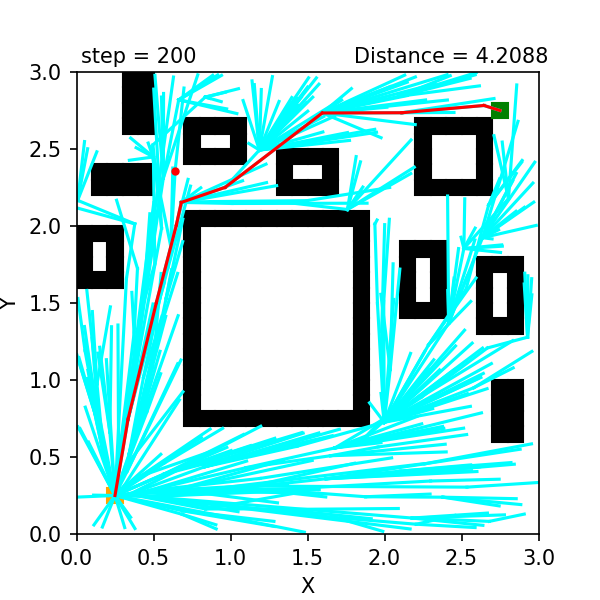

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [6]:
if __name__ == "__main__":
    time_span = 30
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "map.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
    world.append(RRTstar(world, R=7.0, ratioPointGoal=0.95))
    
    world.draw()
    world.ani.save('input_informed.gif', writer='pillow', fps=100)   #uncomment if you want to save a gif 